In [1]:
import pandas as pd
import numpy as np
GBQ_PROJECT_ID = '620265099307'

import datetime
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
from matplotlib import verbose
#verbose.level = 'helpful'      # one of silent, helpful, debug, debug-annoying

# taken from https://github.com/jrmontag/STLDecompose
# requires installation - pip install stldecompose
from stldecompose import decompose
# Simpler smoothing uses:
# from statsmodels.tsa.seasonal import seasonal_decompose

import geopandas as gpd

In [2]:
q='''
SELECT
  p.practice,
  AVG(total_list_size) AS list_size,
  pct,
  prac.setting,
  p.month,
  SUM(IF(p.bnf_code LIKE '1001030U0%AB',
      items,
      0)) AS mtx_2_5,
  SUM(IF(p.bnf_code LIKE '1001030U0%AC',
      items,
      0)) AS mtx_10,
  SUM(IF(p.bnf_code LIKE '1001030U0%CF'
      OR p.bnf_code LIKE '1001030U0%BT'
      OR p.bnf_code LIKE '1001030U0%BU',
      items,
      0)) AS mtx_liq,
  SUM(IF(p.bnf_code LIKE '1001030U0%AH'
      OR p.bnf_code LIKE'1001030U0%AK'
      OR p.bnf_code LIKE'1001030U0%AS'
      OR p.bnf_code LIKE'1001030U0%AR'
      OR p.bnf_code LIKE'1001030U0%AT'
      OR p.bnf_code LIKE'1001030U0%AV'
      OR p.bnf_code LIKE'1001030U0%AE'
      OR p.bnf_code LIKE'1001030U0%AA'
      OR p.bnf_code LIKE'1001030U0%AF'
      OR p.bnf_code LIKE'1001030U0%AI'
      OR p.bnf_code LIKE'1001030U0%AM',
      items,
      0)) AS mtx_liqspec,
  SUM(CASE WHEN((p.bnf_code LIKE '1001030U0%' OR p.bnf_code LIKE '0801030P0%') AND p.bnf_name LIKE '%Inj %') THEN items
      ELSE 0 END) AS mtx_inj,
  SUM(items) AS total_mtxitems
FROM
  ebmdatalab.brian.methotrexate_subset_normalisedpresc AS p
INNER JOIN
  ebmdatalab.hscic.practices prac
ON
  p.practice = prac.code
  AND (prac.setting = 4
    OR prac.setting = 2)
LEFT JOIN
  ebmdatalab.hscic.practice_statistics_all_years AS stat
ON
  p.practice = stat.practice
  AND p.month = stat.month
GROUP BY
  practice,
  pct,
  setting,
  month
ORDER BY
  practice,
  month
'''

all_mtx = pd.read_gbq(q, GBQ_PROJECT_ID, verbose=False, dialect='standard')
ooh_mtx = all_mtx.loc[all_mtx.setting==2]
gp_mtx = all_mtx.loc[all_mtx.setting==4]
all_mtx.info()
gp_mtx.describe()



C:\Users\ajwalker\Anaconda3\lib\site-packages\pandas\io\gbq.py:149: FutureWarning: verbose is deprecated and will be removed in a future version. Set logging level in order to vary verbosity
  credentials=credentials, verbose=verbose, private_key=private_key)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 707686 entries, 0 to 707685
Data columns (total 11 columns):
practice          707686 non-null object
list_size         689661 non-null float64
pct               707686 non-null object
setting           707686 non-null int64
month             707686 non-null datetime64[ns]
mtx_2_5           707686 non-null int64
mtx_10            707686 non-null int64
mtx_liq           707686 non-null int64
mtx_liqspec       707686 non-null int64
mtx_inj           707686 non-null int64
total_mtxitems    707686 non-null int64
dtypes: datetime64[ns](1), float64(1), int64(7), object(2)
memory usage: 59.4+ MB


,list_size,setting,mtx_2_5,mtx_10,mtx_liq,mtx_liqspec,mtx_inj,total_mtxitems
count,689644.000000,705775.0,705775.000000,705775.000000,705775.000000,705775.000000,705775.000000,705775.000000
mean,7391.970240,4.0,18.616233,1.160366,0.003532,0.004596,1.291111,21.075839
std,4485.671671,0.0,15.660416,3.224729,0.072191,0.082838,3.857529,18.048776
min,0.000000,4.0,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,3995.000000,4.0,7.000000,0.000000,0.000000,0.000000,0.000000,8.000000
50%,6550.000000,4.0,15.000000,0.000000,0.000000,0.000000,0.000000,16.000000
75%,9893.000000,4.0,26.000000,1.000000,0.000000,0.000000,1.000000,29.000000
max,72412.000000,4.0,193.000000,74.000000,12.000000,11.000000,265.000000,349.000000


In [3]:
gp_mtx

,practice,list_size,pct,setting,month,mtx_2_5,mtx_10,mtx_liq,mtx_liqspec,mtx_inj,total_mtxitems
0,A81001,NaN,00K,4,2010-08-01,1,0,0,0,0,1
1,A81001,NaN,00K,4,2010-09-01,2,0,0,0,0,2
2,A81001,4241.0,00K,4,2010-10-01,2,0,0,0,0,2
3,A81001,4241.0,00K,4,2010-11-01,2,0,0,0,0,2
4,A81001,4241.0,00K,4,2010-12-01,2,0,0,0,0,2
5,A81001,4217.0,00K,4,2011-01-01,3,0,0,0,0,3
6,A81001,4217.0,00K,4,2011-02-01,1,0,0,0,0,1
7,A81001,4217.0,00K,4,2011-03-01,3,0,0,0,0,3
8,A81001,4186.0,00K,4,2011-04-01,2,0,0,0,0,2
9,A81001,4186.0,00K,4,2011-05-01,2,0,0,0,0,2


In [4]:
pc = gp_mtx.copy()

pc["2.5mg tabs"] = 100*(pc.mtx_2_5/pc.total_mtxitems).fillna(0)
pc["10mg tabs"] = 100*(pc.mtx_10/pc.total_mtxitems).fillna(0)
pc["liquid"] = 100*(pc.mtx_liq/pc.total_mtxitems).fillna(0)
pc["liquid specials"] = 100*(pc.mtx_liqspec/pc.total_mtxitems).fillna(0)
pc["injections"] = 100*(pc.mtx_inj/pc.total_mtxitems).fillna(0)
pc["10mg measure"] = 100*(pc.mtx_10/(pc.mtx_10+pc.mtx_2_5)).fillna(0)

pc.head()

,practice,list_size,pct,setting,month,mtx_2_5,mtx_10,mtx_liq,mtx_liqspec,mtx_inj,total_mtxitems,2.5mg tabs,10mg tabs,liquid,liquid specials,injections,10mg measure
0,A81001,NaN,00K,4,2010-08-01,1,0,0,0,0,1,100.0,0.0,0.0,0.0,0.0,0.0
1,A81001,NaN,00K,4,2010-09-01,2,0,0,0,0,2,100.0,0.0,0.0,0.0,0.0,0.0
2,A81001,4241.0,00K,4,2010-10-01,2,0,0,0,0,2,100.0,0.0,0.0,0.0,0.0,0.0
3,A81001,4241.0,00K,4,2010-11-01,2,0,0,0,0,2,100.0,0.0,0.0,0.0,0.0,0.0
4,A81001,4241.0,00K,4,2010-12-01,2,0,0,0,0,2,100.0,0.0,0.0,0.0,0.0,0.0


In [5]:
pc.practice.drop_duplicates().count()

8109

In [6]:
pc.pct.drop_duplicates().count()

235

In [7]:
# 2017 Counts for BSA FOI Denominator
bsafiltered = pc.copy().loc[(pc.list_size>1000) & (pc["month"]>"2017-01-01") & (pc["month"]< "2018-01-01")] 
bsafiltered.head()

,practice,list_size,pct,setting,month,mtx_2_5,mtx_10,mtx_liq,mtx_liqspec,mtx_inj,total_mtxitems,2.5mg tabs,10mg tabs,liquid,liquid specials,injections,10mg measure
78,A81001,4178.0,00K,4,2017-02-01,9,0,0,0,0,9,100.0,0.0,0.0,0.0,0.0,0.0
79,A81001,4178.0,00K,4,2017-03-01,16,0,0,0,0,16,100.0,0.0,0.0,0.0,0.0,0.0
80,A81001,4150.0,00K,4,2017-04-01,13,0,0,0,0,13,100.0,0.0,0.0,0.0,0.0,0.0
81,A81001,4165.0,00K,4,2017-05-01,13,0,0,0,0,13,100.0,0.0,0.0,0.0,0.0,0.0
82,A81001,4175.0,00K,4,2017-06-01,16,0,0,0,0,16,100.0,0.0,0.0,0.0,0.0,0.0


In [8]:
bsafiltered.practice.drop_duplicates().count()

7349

In [9]:
# 2017 range for practices in 2018
practice_range = pc.copy().loc[(pc.list_size>1000) & (pc["month"]== "2018-04-01")] 
practice_range.describe()

,list_size,setting,mtx_2_5,mtx_10,mtx_liq,mtx_liqspec,mtx_inj,total_mtxitems,2.5mg tabs,10mg tabs,liquid,liquid specials,injections,10mg measure
count,7004.000000,7004.0,7004.000000,7004.000000,7004.000000,7004.000000,7004.000000,7004.000000,7004.000000,7004.000000,7004.000000,7004.000000,7004.000000,7004.000000
mean,8335.296259,4.0,20.578669,0.723587,0.007139,0.001142,2.626499,23.937036,88.058625,3.910482,0.029237,0.003492,7.998164,4.083637
std,5120.521580,0.0,17.186837,2.324486,0.089138,0.037771,5.622151,20.871903,15.569755,10.702815,0.563626,0.126416,12.847254,11.061233
min,1001.000000,4.0,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,4702.750000,4.0,8.000000,0.000000,0.000000,0.000000,0.000000,9.000000,80.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,7387.500000,4.0,16.000000,0.000000,0.000000,0.000000,0.000000,19.000000,94.230769,0.000000,0.000000,0.000000,0.000000,0.000000
75%,10820.000000,4.0,28.000000,0.000000,0.000000,0.000000,3.000000,32.000000,100.000000,0.000000,0.000000,0.000000,13.333333,0.000000
max,72227.000000,4.0,172.000000,49.000000,2.000000,2.000000,82.000000,227.000000,100.000000,100.000000,28.571429,7.142857,100.000000,100.000000


In [10]:
# filter for normal practices
filtered = pc.copy().loc[(pc.list_size>1000) & (pc["month"]>"2010-09-01") ] 
filtered.head()

x1 = np.arange(0.1, 1, 0.1)
x2 = np.arange(0.01,0.1,0.01)
x3 = np.arange(0.91, 1, 0.01)
x = np.concatenate((x1,x2,x3))

#filtered tables grouped by months
pcf = filtered.groupby('month').quantile(x)

#putting groupby(month) from index back into being a column
pcf = pcf.reset_index().rename(columns={"level_1": 'percentile'})
pcf

,month,percentile,list_size,setting,mtx_2_5,mtx_10,mtx_liq,mtx_liqspec,mtx_inj,total_mtxitems,2.5mg tabs,10mg tabs,liquid,liquid specials,injections,10mg measure
0,2010-10-01,0.10,2462.00,4.0,3.00,0.0,0.0,0.0,0.00,3.00,62.500000,0.000000,0.0,0.0,0.000000,0.000000
1,2010-10-01,0.20,3306.60,4.0,5.00,0.0,0.0,0.0,0.00,6.00,77.142857,0.000000,0.0,0.0,0.000000,0.000000
2,2010-10-01,0.30,4177.70,4.0,7.00,0.0,0.0,0.0,0.00,8.00,86.956522,0.000000,0.0,0.0,0.000000,0.000000
3,2010-10-01,0.40,5187.00,4.0,9.00,0.0,0.0,0.0,0.00,11.00,92.857143,0.000000,0.0,0.0,0.000000,0.000000
4,2010-10-01,0.50,6206.50,4.0,12.00,0.0,0.0,0.0,0.00,14.00,98.113208,0.000000,0.0,0.0,0.000000,0.000000
5,2010-10-01,0.60,7352.00,4.0,15.00,0.0,0.0,0.0,0.00,17.00,100.000000,0.000000,0.0,0.0,0.000000,0.000000
6,2010-10-01,0.70,8678.00,4.0,19.00,1.0,0.0,0.0,0.00,22.00,100.000000,7.692308,0.0,0.0,0.000000,8.124655
7,2010-10-01,0.80,10239.20,4.0,25.00,2.0,0.0,0.0,0.00,27.00,100.000000,18.229665,0.0,0.0,0.000000,18.750000
8,2010-10-01,0.90,12446.10,4.0,33.00,4.0,0.0,0.0,1.00,36.00,100.000000,33.333333,0.0,0.0,6.976744,33.389831
9,2010-10-01,0.01,1551.37,4.0,1.00,0.0,0.0,0.0,0.00,1.00,25.000000,0.000000,0.0,0.0,0.000000,0.000000


In [11]:
pcf.loc[pcf['month']=='2018-04-01']

,month,percentile,list_size,setting,mtx_2_5,mtx_10,mtx_liq,mtx_liqspec,mtx_inj,total_mtxitems,2.5mg tabs,10mg tabs,liquid,liquid specials,injections,10mg measure
2430,2018-04-01,0.10,3140.90,4.0,4.0,0.0,0.0,0.0,0.0,4.00,66.666667,0.000000,0.0,0.0,0.000000,0.000000
2431,2018-04-01,0.20,4181.00,4.0,7.0,0.0,0.0,0.0,0.0,8.00,76.470588,0.000000,0.0,0.0,0.000000,0.000000
2432,2018-04-01,0.30,5199.90,4.0,10.0,0.0,0.0,0.0,0.0,11.00,83.333333,0.000000,0.0,0.0,0.000000,0.000000
2433,2018-04-01,0.40,6262.80,4.0,13.0,0.0,0.0,0.0,0.0,14.00,88.888889,0.000000,0.0,0.0,0.000000,0.000000
2434,2018-04-01,0.50,7387.50,4.0,16.0,0.0,0.0,0.0,0.0,19.00,94.230769,0.000000,0.0,0.0,0.000000,0.000000
2435,2018-04-01,0.60,8620.20,4.0,20.0,0.0,0.0,0.0,1.0,23.00,100.000000,0.000000,0.0,0.0,3.448276,0.000000
2436,2018-04-01,0.70,10060.20,4.0,25.0,0.0,0.0,0.0,2.0,29.00,100.000000,0.000000,0.0,0.0,10.000000,0.000000
2437,2018-04-01,0.80,11750.60,4.0,32.0,1.0,0.0,0.0,4.0,37.00,100.000000,3.413209,0.0,0.0,17.073171,3.703704
2438,2018-04-01,0.90,14340.20,4.0,42.0,2.0,0.0,0.0,8.0,50.00,100.000000,13.793103,0.0,0.0,26.470588,14.285714
2439,2018-04-01,0.01,1822.03,4.0,1.0,0.0,0.0,0.0,0.0,1.00,33.392157,0.000000,0.0,0.0,0.000000,0.000000


In [12]:
count_in_deciles = filtered.loc[(filtered['month']==filtered['month'].max())&(filtered['10mg tabs']>=14.285714)]
len(count_in_deciles)#.count()

697

In [13]:
count_in_deciles = filtered.loc[(filtered['month']==filtered['month'].max())&(filtered['10mg tabs']>=52.371168)]
len(count_in_deciles)#.count()

66

In [14]:
pcf.describe()

,percentile,list_size,setting,mtx_2_5,mtx_10,mtx_liq,mtx_liqspec,mtx_inj,total_mtxitems,2.5mg tabs,10mg tabs,liquid,liquid specials,injections,10mg measure
count,2457.000000,2457.000000,2457.0,2457.000000,2457.000000,2457.0,2457.000000,2457.000000,2457.000000,2457.000000,2457.000000,2457.0,2457.000000,2457.000000,2457.000000
mean,0.500000,8372.581832,4.0,23.351897,2.600965,0.0,0.000814,2.912405,26.605930,81.529074,14.824832,0.0,0.001406,9.200487,15.107062
std,0.397153,6180.842381,0.0,22.240330,4.018271,0.0,0.028525,4.701948,25.518699,22.039576,20.124230,0.0,0.049896,12.670351,20.432466
min,0.010000,1460.360000,4.0,1.000000,0.000000,0.0,0.000000,0.000000,1.000000,24.226190,0.000000,0.0,0.000000,0.000000,0.000000
25%,0.070000,2370.000000,4.0,3.000000,0.000000,0.0,0.000000,0.000000,3.000000,61.538462,0.000000,0.0,0.000000,0.000000,0.000000
50%,0.500000,6453.000000,4.0,15.000000,0.000000,0.0,0.000000,0.000000,17.000000,96.969697,0.000000,0.0,0.000000,0.000000,0.000000
75%,0.930000,14126.300000,4.0,44.000000,4.000000,0.0,0.000000,5.000000,49.000000,100.000000,33.333333,0.0,0.000000,18.181818,33.333333
max,0.990000,24857.850000,4.0,83.050000,19.000000,0.0,1.000000,27.710000,101.000000,100.000000,75.000000,0.0,2.003676,50.000000,75.000000


In [15]:
filtered.practice.drop_duplicates().count()

8045

In [16]:
filtered.pct.drop_duplicates().count()

230

## Practice Level Plots


### Without smoothing

C:\Users\ajwalker\Anaconda3\lib\site-packages\pandas\plotting\_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)
C:\Users\ajwalker\Anaconda3\lib\site-packages\ipykernel_launcher.py:34: UserWarning: Attempting to set identical bottom==top results
in singular transformations; automatically expanding.
bottom=0, top=0.0


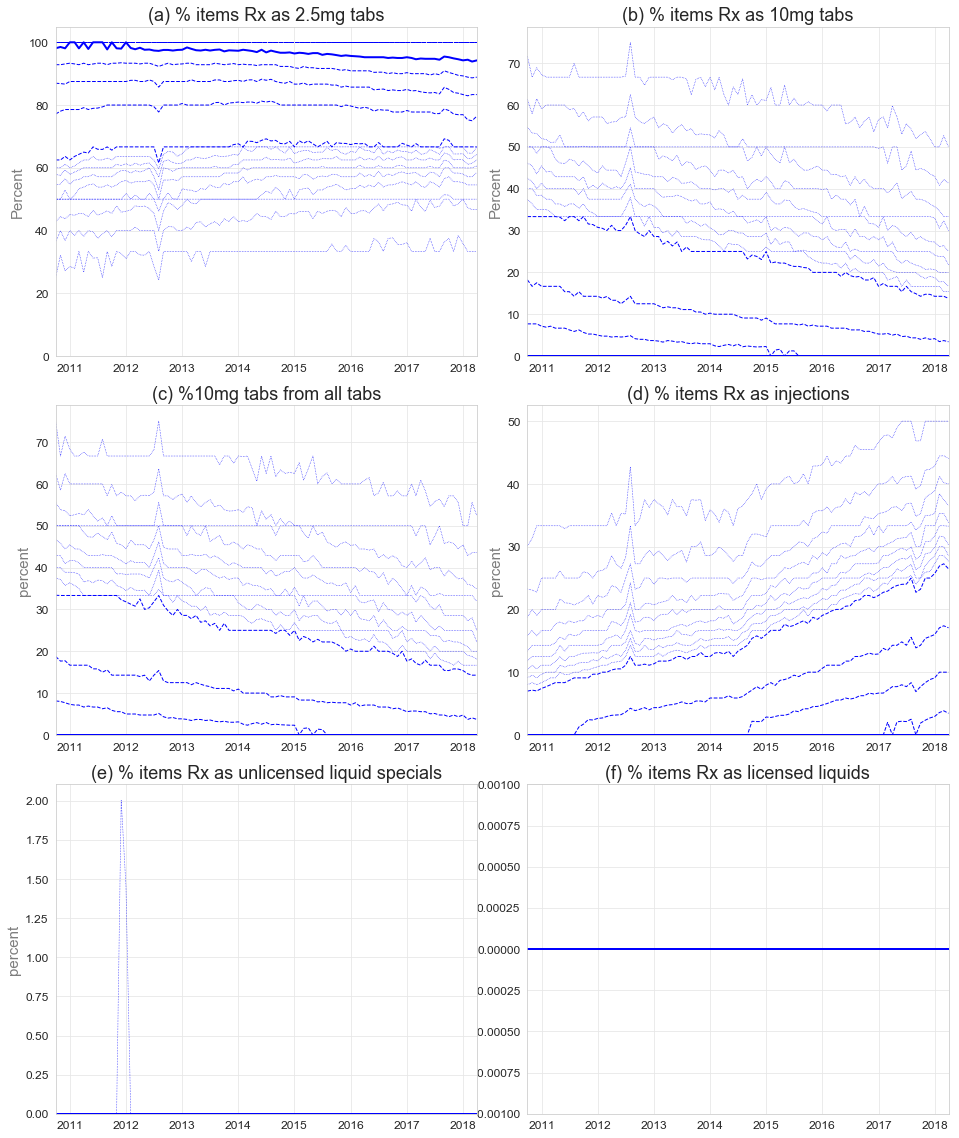

In [17]:
sns.set_style("whitegrid",{'grid.color': '.9'})
dfp = pcf.copy().sort_values(by=["month"])#,"drug"])
dfp['month'] = dfp['month'].astype(str)
# set format for dates:
dfp['dates'] = [datetime.datetime.strptime(date, '%Y-%m-%d').date() for date in dfp['month']]

# set sort order of drugs manually, and add grid refs to position each subplot:
# order is column, title, axis
s = [(0,'2.5mg tabs',0,0,'(a) % items Rx as 2.5mg tabs','Percent'), 
     (1,'10mg tabs',0,1,'(b) % items Rx as 10mg tabs','Percent'),
     (2,'10mg measure',1,0, '(c) %10mg tabs from all tabs', 'percent'),
     (3,'liquid',2,1,'(f) % items Rx as licensed liquids','Percent'), 
     (4,'liquid specials',2,0, '(e) % items Rx as unlicensed liquid specials', 'percent'), 
     (5,'injections',1,1, '(d) % items Rx as injections', 'percent'),]


x = pd.Series(x)
fig = plt.figure(figsize=(16,20)) 
gs = gridspec.GridSpec(3,2)  # grid layout for subplots

# Plot each subplot using a loop
for i in s:
    ax = plt.subplot(gs[i[2], i[3]])  # position of subplot in grid using coordinates listed in s
    for decile in x:   # plot each decile line
        data = dfp.loc[(dfp['percentile']==decile)]#(dfp['drug']==i[1]) & 
        if decile == .5:
            ax.plot(data["dates"],data[i[1]],'b-',linewidth=2)
        elif (decile <0.1) | (decile >0.9):
            ax.plot(data["dates"],data[i[1]],'b:',linewidth=0.6)
        else:
            ax.plot(data["dates"],data[i[1]],'b--',linewidth=1)
    ax.set_ylabel(i[5], size =15, alpha=0.6)
    ax.set_title(i[4],size = 18)
    ax.set_ylim([0, dfp[i[1]].max()*1.05])  # set ymax across all subplots as largest value across dataset
    ax.tick_params(labelsize=12)
    ax.set_xlim([dfp['dates'].min(), dfp['dates'].max()]) # set x axis range as full date range

plt.subplots_adjust(wspace = 0.12,hspace = 0.15)
plt.savefig('practice_deciles_no_smooth.png', format='png', dpi=300,bbox_inches='tight')
plt.show()

### CCG Level Plots

In [18]:
ccg_aggregate = gp_mtx.copy()
ccg_grouping = ccg_aggregate.groupby(['pct', 'month']).sum()


In [ ]:
ccg_grouping = ccg_grouping.reset_index()
ccg_grouping

,pct,month,list_size,setting,mtx_2_5,mtx_10,mtx_liq,mtx_liqspec,mtx_inj,total_mtxitems
0,00C,2010-08-01,0.0,44,257,3,0,1,1,262
1,00C,2010-09-01,0.0,44,270,1,0,2,0,273
2,00C,2010-10-01,105589.0,44,243,0,0,0,1,244
3,00C,2010-11-01,105589.0,44,246,0,0,1,0,247
4,00C,2010-12-01,105996.0,48,295,1,0,2,1,299
5,00C,2011-01-01,105453.0,48,237,1,0,1,1,240
6,00C,2011-02-01,105453.0,48,241,1,0,2,2,246
7,00C,2011-03-01,105453.0,48,272,1,0,2,1,276
8,00C,2011-04-01,105196.0,44,253,0,0,2,0,255
9,00C,2011-05-01,105613.0,48,272,0,0,2,1,275


In [ ]:
ccgpc = ccg_grouping.copy()

ccgpc["2.5mg tabs"] = 100*(ccgpc.mtx_2_5/ccgpc.total_mtxitems).fillna(0)
ccgpc["10mg tabs"] = 100*(ccgpc.mtx_10/ccgpc.total_mtxitems).fillna(0)
ccgpc["liquid"] = 100*(ccgpc.mtx_liq/ccgpc.total_mtxitems).fillna(0)
ccgpc["liquid specials"] = 100*(ccgpc.mtx_liqspec/ccgpc.total_mtxitems).fillna(0)
ccgpc["injections"] = 100*(ccgpc.mtx_inj/ccgpc.total_mtxitems).fillna(0)
ccgpc["10mg measure"] = 100*(ccgpc.mtx_10/(ccgpc.mtx_10+ccgpc.mtx_2_5)).fillna(0)

ccgpc.head()

,pct,month,list_size,setting,mtx_2_5,mtx_10,mtx_liq,mtx_liqspec,mtx_inj,total_mtxitems,2.5mg tabs,10mg tabs,liquid,liquid specials,injections,10mg measure
0,00C,2010-08-01,0.0,44,257,3,0,1,1,262,98.091603,1.145038,0.0,0.381679,0.381679,1.153846
1,00C,2010-09-01,0.0,44,270,1,0,2,0,273,98.901099,0.366300,0.0,0.732601,0.000000,0.369004
2,00C,2010-10-01,105589.0,44,243,0,0,0,1,244,99.590164,0.000000,0.0,0.000000,0.409836,0.000000
3,00C,2010-11-01,105589.0,44,246,0,0,1,0,247,99.595142,0.000000,0.0,0.404858,0.000000,0.000000
4,00C,2010-12-01,105996.0,48,295,1,0,2,1,299,98.662207,0.334448,0.0,0.668896,0.334448,0.337838


In [ ]:
ccgpc.pct.drop_duplicates().count()

235

In [ ]:
# filter for normal CCGs
filtered = ccgpc.copy().loc[(ccgpc.list_size>10000) & (ccgpc["month"]>"2010-09-01") ] 
filtered.head()

x1 = np.arange(0.1, 1, 0.1)
x2 = np.arange(0.01,0.1,0.01)
x3 = np.arange(0.91, 1, 0.01)
x = np.concatenate((x1,x2,x3))

#filtered tables grouped by months
ccgpcf = filtered.groupby('month').quantile(x)

#putting groupby(month) from index back into being a column
ccgpcf = ccgpcf.reset_index().rename(columns={"level_1": 'percentile'})
ccgpcf

,month,percentile,list_size,setting,mtx_2_5,mtx_10,mtx_liq,mtx_liqspec,mtx_inj,total_mtxitems,2.5mg tabs,10mg tabs,liquid,liquid specials,injections,10mg measure
0,2010-10-01,0.10,120733.30,64.00,234.60,1.10,0.00,0.00,0.00,258.80,72.479624,0.308872,0.000000,0.000000,0.000000,0.318987
1,2010-10-01,0.20,157530.80,84.00,305.40,4.00,0.00,0.00,1.00,348.20,80.918918,0.642310,0.000000,0.000000,0.121392,0.672335
2,2010-10-01,0.30,179950.90,104.00,366.40,8.00,0.00,0.00,1.00,409.60,87.383126,1.538462,0.000000,0.000000,0.304073,1.551954
3,2010-10-01,0.40,203201.40,117.60,408.40,14.40,0.00,0.00,2.00,470.20,90.065804,3.009349,0.000000,0.000000,0.434413,3.078323
4,2010-10-01,0.50,228661.00,136.00,479.50,21.50,0.00,0.00,3.00,522.50,92.987708,4.730026,0.000000,0.000000,0.608522,4.864759
5,2010-10-01,0.60,260996.00,154.40,538.20,35.60,0.00,0.00,4.00,590.20,94.680463,6.954055,0.000000,0.000000,0.814384,7.028032
6,2010-10-01,0.70,289474.20,178.80,656.40,50.70,0.00,0.00,8.00,709.20,96.347800,9.905405,0.000000,0.000000,1.306310,10.001348
7,2010-10-01,0.80,336459.20,208.00,808.00,76.00,0.00,1.00,14.80,889.20,97.875775,15.404056,0.000000,0.114673,2.690091,15.770282
8,2010-10-01,0.90,470067.60,252.00,1118.80,121.80,0.00,2.00,42.60,1230.40,98.890737,26.596378,0.000000,0.222279,5.309050,26.828597
9,2010-10-01,0.01,16147.01,16.04,30.01,0.00,0.00,0.00,0.00,41.11,50.036585,0.000000,0.000000,0.000000,0.000000,0.000000


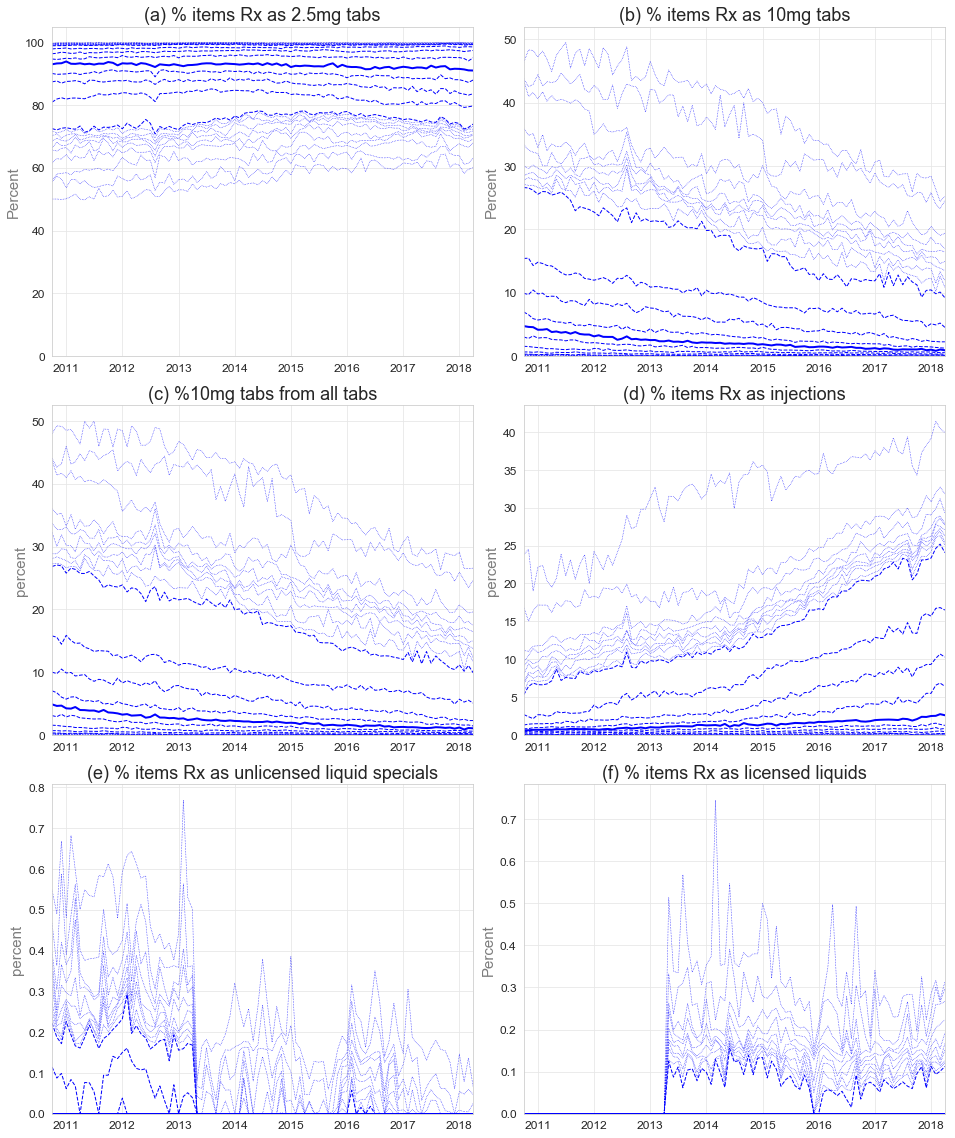

In [ ]:
sns.set_style("whitegrid",{'grid.color': '.9'})
dfp = ccgpcf.copy().sort_values(by=["month"])#,"drug"])
dfp['month'] = dfp['month'].astype(str)
# set format for dates:
dfp['dates'] = [datetime.datetime.strptime(date, '%Y-%m-%d').date() for date in dfp['month']]

# set sort order of drugs manually, and add grid refs to position each subplot:
# order is column, title, axis
s = [(0,'2.5mg tabs',0,0,'(a) % items Rx as 2.5mg tabs','Percent'), 
     (1,'10mg tabs',0,1,'(b) % items Rx as 10mg tabs','Percent'),
     (2,'10mg measure',1,0, '(c) %10mg tabs from all tabs', 'percent'),
     (3,'liquid',2,1,'(f) % items Rx as licensed liquids','Percent'), 
     (4,'liquid specials',2,0, '(e) % items Rx as unlicensed liquid specials', 'percent'), 
     (5,'injections',1,1, '(d) % items Rx as injections', 'percent'),]


x = pd.Series(x)
fig = plt.figure(figsize=(16,20)) 
gs = gridspec.GridSpec(3,2)  # grid layout for subplots

# Plot each subplot using a loop
for i in s:
    ax = plt.subplot(gs[i[2], i[3]])  # position of subplot in grid using coordinates listed in s
    for decile in x:   # plot each decile line
        data = dfp.loc[(dfp['percentile']==decile)]#(dfp['drug']==i[1]) & 
        if decile == .5:
            ax.plot(data["dates"],data[i[1]],'b-',linewidth=2)
        elif (decile <0.1) | (decile >0.9):
            ax.plot(data["dates"],data[i[1]],'b:',linewidth=0.6)
        else:
            ax.plot(data["dates"],data[i[1]],'b--',linewidth=1)
    ax.set_ylabel(i[5], size =15, alpha=0.6)
    ax.set_title(i[4],size = 18)
    ax.set_ylim([0, dfp[i[1]].max()*1.05])  # set ymax across all subplots as largest value across dataset
    ax.tick_params(labelsize=12)
    ax.set_xlim([dfp['dates'].min(), dfp['dates'].max()]) # set x axis range as full date range

plt.subplots_adjust(wspace = 0.12,hspace = 0.15)
plt.savefig('ccg_deciles_no_smooth.png', format='png', dpi=300,bbox_inches='tight')
plt.show()

In [ ]:
ccgpcf.month.min()

Timestamp('2010-10-01 00:00:00')

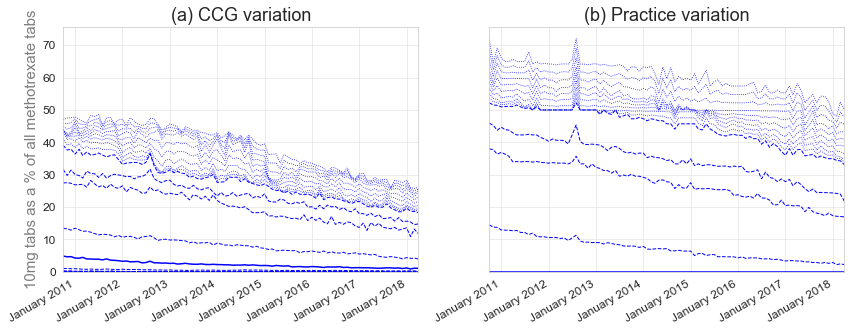

In [ ]:
from ebmdatalab import charts
f = plt.figure(figsize=(14, 5))
#f.suptitle('Sharing Y axis')
f.autofmt_xdate()
layout = gridspec.GridSpec(1, 2, figure=f)
left_plot = plt.subplot(layout[0])
right_plot = plt.subplot(layout[1], sharey=left_plot)  # Share the Y axis 
# ...and because it's shared, suppress ticks on the second chart
plt.setp(right_plot.get_yticklabels(), visible=False)  

charts.deciles_chart(
    ccgpcf,
    period_column='month',
    column='10mg measure',
    title="(a) CCG variation",
    ylabel="10mg tabs as a % of all methotrexate tabs",
    show_outer_percentiles=True,
    show_legend=False,
    ax=left_plot
)

charts.deciles_chart(
    pcf,
    period_column='month',
    column='10mg measure',
    title="(b) Practice variation",
    ylabel="",
    show_outer_percentiles=True,
    show_legend=False,
    ax=right_plot
)
plt.savefig('deciles.png', format='png', dpi=300,bbox_inches='tight')
plt.show()

### Total Items in standard practices

In [ ]:
### decline in 10mg
ten_mgitems = gp_mtx.groupby('month').sum()[('mtx_10')]
ten_mgitems

month
2010-08-01    11715
2010-09-01    12171
2010-10-01    11567
2010-11-01    11612
2010-12-01    12249
2011-01-01    10766
2011-02-01    10258
2011-03-01    11567
2011-04-01    10505
2011-05-01    11161
2011-06-01    11189
2011-07-01    11033
2011-08-01    11077
2011-09-01    11360
2011-10-01    10629
2011-11-01    10728
2011-12-01    11235
2012-01-01    10319
2012-02-01    10076
2012-03-01    10887
2012-04-01     9975
2012-05-01    10975
2012-06-01    10069
2012-07-01    10244
2012-08-01    10533
2012-09-01     9924
2012-10-01    10388
2012-11-01    10095
2012-12-01    10086
2013-01-01    10089
              ...  
2015-11-01     7755
2015-12-01     8426
2016-01-01     7378
2016-02-01     7247
2016-03-01     7473
2016-04-01     7612
2016-05-01     7197
2016-06-01     7445
2016-07-01     7324
2016-08-01     7101
2016-09-01     7213
2016-10-01     6840
2016-11-01     6833
2016-12-01     7107
2017-01-01     6446
2017-02-01     6069
2017-03-01     6682
2017-04-01     6007
2017-05-01    

In [ ]:
###10/2.5mg ratio
ratioprep = gp_mtx.groupby('month').sum()[['mtx_10','mtx_2_5']]
ratioprep
###pc["10mg measure"] = 100*(pc.mtx_10/(pc.mtx_10+pc.mtx_2_5)).fillna(0)

,mtx_10,mtx_2_5
month,,
2010-08-01,11715,117231
2010-09-01,12171,124616
2010-10-01,11567,118520
2010-11-01,11612,121915
2010-12-01,12249,132148
2011-01-01,10766,117316
2011-02-01,10258,113935
2011-03-01,11567,130867
2011-04-01,10505,120903


In [ ]:
ratioprep['10mg measure'] = 100*(ratioprep['mtx_10']/(ratioprep['mtx_10']+ratioprep['mtx_2_5']))
ratioprep




,mtx_10,mtx_2_5,10mg measure
month,,,
2010-08-01,11715,117231,9.085198
2010-09-01,12171,124616,8.897775
2010-10-01,11567,118520,8.891742
2010-11-01,11612,121915,8.696369
2010-12-01,12249,132148,8.482863
2011-01-01,10766,117316,8.405553
2011-02-01,10258,113935,8.259725
2011-03-01,11567,130867,8.120954
2011-04-01,10505,120903,7.994186


C:\Users\ajwalker\Anaconda3\lib\site-packages\matplotlib\axes\_base.py:3604: MatplotlibDeprecationWarning: 
The `ymin` argument was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use `bottom` instead.
  alternative='`bottom`', obj_type='argument')
C:\Users\ajwalker\Anaconda3\lib\site-packages\matplotlib\axes\_base.py:3604: MatplotlibDeprecationWarning: 
The `ymin` argument was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use `bottom` instead.
  alternative='`bottom`', obj_type='argument')
C:\Users\ajwalker\Anaconda3\lib\site-packages\matplotlib\axes\_base.py:3604: MatplotlibDeprecationWarning: 
The `ymin` argument was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use `bottom` instead.
  alternative='`bottom`', obj_type='argument')
C:\Users\ajwalker\Anaconda3\lib\site-packages\matplotlib\axes\_base.py:3604: MatplotlibDeprecationWarning: 
The `ymin` argument was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use `bottom` instead.
  alternative='

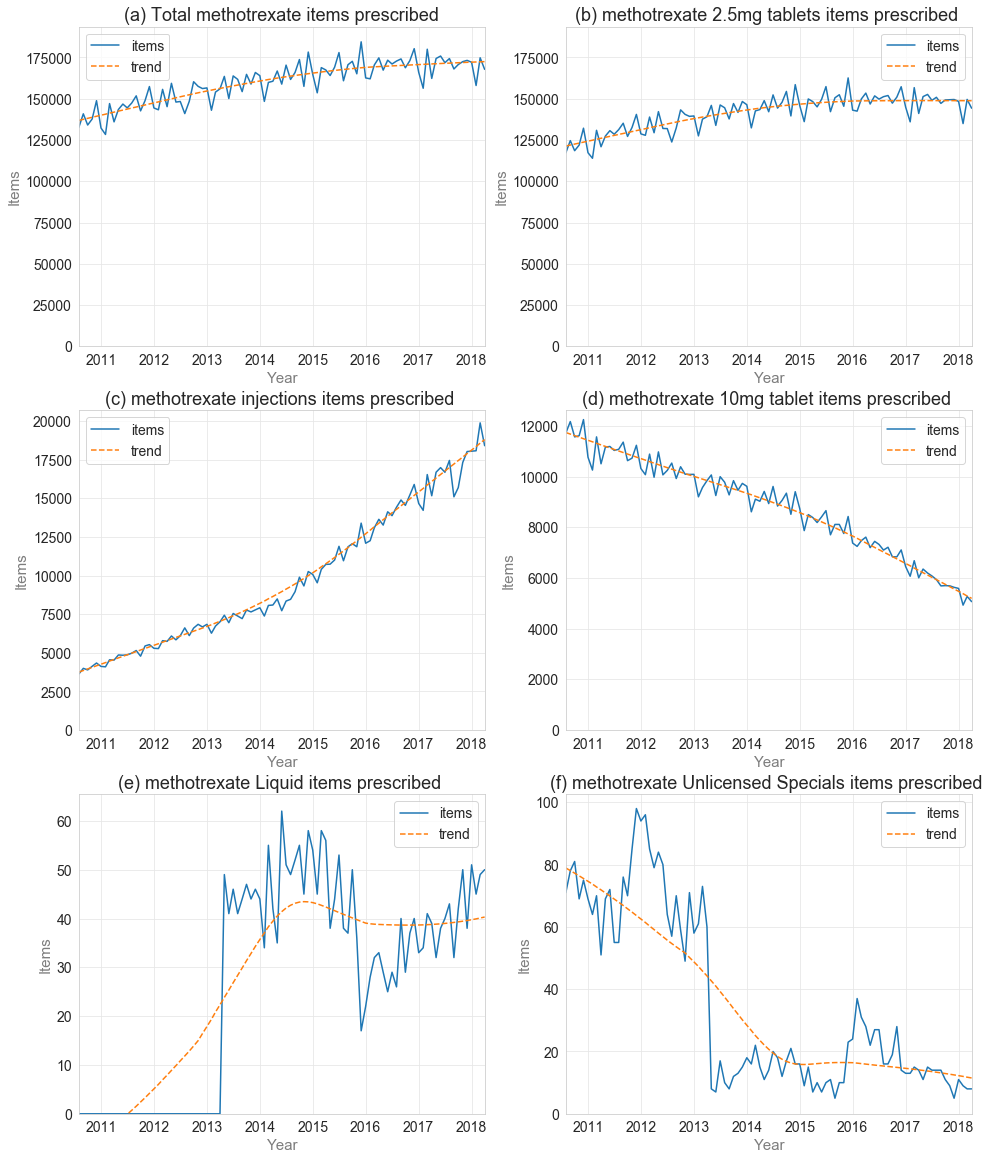

In [ ]:
# total items in standard practices = 4

sns.set_style("whitegrid",{'grid.color': '.9'})
dfp = gp_mtx.sort_values(by=["month"])#,"drug"])
dfp['month_str'] = dfp['month'].astype(str)
# set format for dates:
dfp['dates'] = [datetime.datetime.strptime(date, '%Y-%m-%d').date() for date in dfp['month_str']]

fig = plt.figure(figsize=(16,20)) 
gs = gridspec.GridSpec(3,2)  # grid layout for subplots


# for smoothing, dataframe needs to be non-missing and have a DateTime index
data = gp_mtx.groupby('month').sum()[['total_mtxitems','list_size']]
data = pd.DataFrame(data['total_mtxitems'])
data['total_mtxitems'] = data["total_mtxitems"]

calc = decompose(data, period=12, lo_frac=0.6, lo_delta=0.0)
average = data.sum()/ (len(data))
flat = ((data-calc.trend))#/data)*100
#total items
ax = plt.subplot(gs[0,0])
ax.plot(data,label='items')
ax.plot(calc.trend,'--',label='trend')
ax.set_ylabel('Items', size =15, alpha=0.6)
ax.set_xlabel('Year', size =15, alpha=0.6)
ax.set_title('(a) Total methotrexate items prescribed',size = 18)
ax.tick_params(labelsize=14)
ax.set_xlim([dfp['dates'].min(), dfp['dates'].max()]) # set x axis range as full date range
max_value = data["total_mtxitems"].max()*1.05
ax.set_ylim([0,max_value])
ax.legend(prop={'size': 14})


#2.5mg tabs
ax = plt.subplot(gs[0,1])
data = gp_mtx.groupby('month').sum()[['mtx_2_5', 'list_size']]
data = pd.DataFrame(data['mtx_2_5'])

calc = decompose(data, period=12, lo_frac=0.6, lo_delta=0.0)
average = data.sum()/ (len(data))
flat = ((data-calc.trend))

ax.plot(data,label='items')
ax.plot(calc.trend,'--',label='trend')
ax.set_ylabel('Items', size =15, alpha=0.6)
ax.set_xlabel('Year', size =15, alpha=0.6)
ax.set_title('(b) methotrexate 2.5mg tablets items prescribed ',size = 18)
ax.tick_params(labelsize=14)
ax.set_xlim([dfp['dates'].min(), dfp['dates'].max()]) # set x axis range as full date range
ax.set_ylim([0,max_value])
ax.legend(prop={'size': 14})


#injections
ax = plt.subplot(gs[1,0])
data = gp_mtx.groupby('month').sum()[['mtx_inj','list_size']]
data = pd.DataFrame(data['mtx_inj'])

calc = decompose(data, period=12, lo_frac=0.6, lo_delta=0.0)
average = data.sum()/ (len(data))
flat = ((data-calc.trend))

ax.plot(data,label='items')
ax.plot(calc.trend,'--',label='trend')
ax.set_ylabel('Items', size =15, alpha=0.6)
ax.set_xlabel('Year', size =15, alpha=0.6)
ax.set_title('(c) methotrexate injections items prescribed ',size = 18)
ax.tick_params(labelsize=14)
ax.set_xlim([dfp['dates'].min(), dfp['dates'].max()]) # set x axis range as full date range
ax.set_ylim(ymin=0)
ax.legend(prop={'size': 14})


#10mg tablets
ax = plt.subplot(gs[1,1])
data = gp_mtx.groupby('month').sum()[['mtx_10','list_size']]
data = pd.DataFrame(data['mtx_10'])

calc = decompose(data, period=12, lo_frac=0.6, lo_delta=0.0)
average = data.sum()/ (len(data))
flat = ((data-calc.trend))

ax.plot(data,label='items')
ax.plot(calc.trend,'--',label='trend')
ax.set_ylabel('Items', size =15, alpha=0.6)
ax.set_xlabel('Year', size =15, alpha=0.6)
ax.set_title('(d) methotrexate 10mg tablet items prescribed ',size = 18)
ax.tick_params(labelsize=14)
ax.set_xlim([dfp['dates'].min(), dfp['dates'].max()]) # set x axis range as full date range
ax.set_ylim(ymin=0)
ax.legend(prop={'size': 14})



#liquids 
ax = plt.subplot(gs[2,0])
data = gp_mtx.groupby('month').sum()[['mtx_liq','list_size']]
data = pd.DataFrame(data['mtx_liq'])

calc = decompose(data, period=12, lo_frac=0.6, lo_delta=0.0)
average = data.sum()/ (len(data))
flat = ((data-calc.trend))

ax.plot(data,label='items')
ax.plot(calc.trend,'--',label='trend')
ax.set_ylabel('Items', size =15, alpha=0.6)
ax.set_xlabel('Year', size =15, alpha=0.6)
ax.set_title('(e) methotrexate Liquid items prescribed ',size = 18)
ax.tick_params(labelsize=14)
ax.set_xlim([dfp['dates'].min(), dfp['dates'].max()]) # set x axis range as full date range
ax.set_ylim(ymin=0)
ax.legend(prop={'size': 14})


#specials 
ax = plt.subplot(gs[2,1])
data = gp_mtx.groupby('month').sum()[['mtx_liqspec','list_size']]
data = pd.DataFrame(data['mtx_liqspec'])

calc = decompose(data, period=12, lo_frac=0.6, lo_delta=0.0)
average = data.sum()/ (len(data))
flat = ((data-calc.trend))

ax.plot(data,label='items')
ax.plot(calc.trend,'--',label='trend')
ax.set_ylabel('Items', size =15, alpha=0.6)
ax.set_xlabel('Year', size =15, alpha=0.6)
ax.set_title('(f) methotrexate Unlicensed Specials items prescribed ',size = 18)
ax.tick_params(labelsize=14)
ax.set_xlim([dfp['dates'].min(), dfp['dates'].max()]) # set x axis range as full date range
ax.set_ylim(ymin=0)
ax.legend(prop={'size': 14})


plt.show()

# # MAPS

In [ ]:
#aggregate over last year
ccg_last_year = gp_mtx.groupby(['pct','month'],as_index=False).sum()
ccg_last_year = ccg_last_year.loc[ccg_last_year["month"] >'2017-05-01'] #check when data final with alex


#ccg_last_year = all_mtx_ccg.loc[all_mtx_ccg.month]
ccg_last_year = ccg_last_year.groupby('pct').sum()
ccg_last_year["list_size"] = ccg_last_year["list_size"]/12

ccg_last_year["2.5mg tabs"] = 100*(ccg_last_year.mtx_2_5/ccg_last_year.total_mtxitems).fillna(0)
ccg_last_year["10mg tabs"] = 100*(ccg_last_year.mtx_10/ccg_last_year.total_mtxitems).fillna(0)
ccg_last_year["injections"] = 100*(ccg_last_year.mtx_inj/ccg_last_year.total_mtxitems).fillna(0)
ccg_last_year["total_mtx_items"] = (ccg_last_year.total_mtxitems)/ccg_last_year["list_size"].fillna(0)
ccg_last_year["10mg measure"] = 100*(ccg_last_year.mtx_10/(ccg_last_year.mtx_10+ccg_last_year.mtx_2_5)).fillna(0)

ccg_last_year.head()

,list_size,setting,mtx_2_5,mtx_10,mtx_liq,mtx_liqspec,mtx_inj,total_mtxitems,2.5mg tabs,10mg tabs,injections,total_mtx_items,10mg measure
pct,,,,,,,,,,,,,
00C,99132.000000,484,3521,1,0,0,22,3544,99.351016,0.028217,0.620767,0.035750,0.028393
00D,267178.000000,1668,9302,2,0,0,63,9367,99.306075,0.021352,0.672574,0.035059,0.021496
00J,236551.750000,1364,8705,1,11,0,96,8813,98.774538,0.011347,1.089300,0.037256,0.011486
00K,262766.000000,1380,6256,99,0,0,3,6358,98.395722,1.557093,0.047185,0.024196,1.557828
00L,295240.333333,1864,11588,63,0,0,26,11677,99.237818,0.539522,0.222660,0.039551,0.540726


In [ ]:
ccg_last_year.describe()

,list_size,setting,mtx_2_5,mtx_10,mtx_liq,mtx_liqspec,mtx_inj,total_mtxitems,2.5mg tabs,10mg tabs,injections,total_mtx_items,10mg measure
count,1.960000e+02,196.000000,196.000000,196.000000,196.000000,196.000000,196.000000,196.000000,196.000000,196.000000,196.000000,196.000000,196.000000
mean,2.719430e+05,1596.775510,8290.882653,315.224490,2.438776,0.602041,978.173469,9587.321429,89.018329,3.504118,7.449969,0.035230,3.659523
std,1.640212e+05,941.908009,6102.136156,833.188458,4.994492,2.768837,1739.564915,7589.691052,9.973772,6.045573,9.388912,0.013314,6.199943
min,3.991583e+03,44.000000,181.000000,0.000000,0.000000,0.000000,0.000000,234.000000,59.005043,0.000000,0.000000,0.002948,0.000000
25%,1.694093e+05,968.000000,4590.750000,25.750000,0.000000,0.000000,37.000000,5059.250000,82.637060,0.260214,0.616344,0.025742,0.288895
50%,2.345335e+05,1384.000000,6466.500000,71.000000,0.000000,0.000000,148.000000,7379.000000,91.459096,1.011658,2.350634,0.035618,1.080419
75%,3.044849e+05,1941.000000,9505.000000,263.250000,3.000000,0.000000,1182.250000,10736.750000,98.049285,3.997132,11.813363,0.042162,4.111663
max,1.152406e+06,7332.000000,37405.000000,9072.000000,35.000000,33.000000,9696.000000,43644.000000,99.921229,36.491228,40.935123,0.088711,37.625892


In [ ]:
london_ccg = ["08H", "07L", "07M", "07N", "08M", "07P", "07Q", "07R", "09A", "07T", "07V", "07X", "07W", "08A", "08C", "08D", "08E", "08F", "08G", "07Y", "08J", "08K", "08L", "08R", "08Q", "08T", "08V", "08W", "08X", "08Y", "08M", "08N", "08P"]
london_ccg = pd.DataFrame(london_ccg).set_index(0)
london_ccg = ccg_last_year.merge(london_ccg, how="inner",left_index=True,right_index=True)
london_ccg.head()

,list_size,setting,mtx_2_5,mtx_10,mtx_liq,mtx_liqspec,mtx_inj,total_mtxitems,2.5mg tabs,10mg tabs,injections,total_mtx_items,10mg measure
07L,203794.666667,1632,4960,361,5,0,682,6008,82.556591,6.008655,11.351531,0.029481,6.784439
07M,377608.750000,2500,4620,428,0,0,120,5168,89.396285,8.281734,2.321981,0.013686,8.478605
07N,219088.500000,1156,4475,1789,0,0,104,6368,70.273241,28.093593,1.633166,0.029066,28.560026
07P,340635.916667,2644,4415,550,0,0,13,4978,88.690237,11.048614,0.261149,0.014614,11.077543
07Q,317843.833333,1956,7027,497,4,0,112,7640,91.976440,6.505236,1.465969,0.024037,6.605529


In [ ]:
london_ccg.describe()

,list_size,setting,mtx_2_5,mtx_10,mtx_liq,mtx_liqspec,mtx_inj,total_mtxitems,2.5mg tabs,10mg tabs,injections,total_mtx_items,10mg measure
count,33.000000,33.000000,33.000000,33.000000,33.000000,33.000000,33.000000,33.000000,33.000000,33.000000,33.000000,33.000000,33.000000
mean,277012.118687,1751.030303,4298.242424,511.333333,1.696970,0.393939,185.363636,4997.030303,86.494071,10.095583,3.371362,0.018465,10.292169
std,63756.060050,507.553968,1470.561224,474.834094,3.216023,1.390580,282.600294,1742.754402,6.477436,7.515179,4.219760,0.006790,7.560867
min,176518.250000,932.000000,1795.000000,52.000000,0.000000,0.000000,4.000000,2161.000000,70.273241,0.836703,0.080890,0.010312,0.870322
25%,219088.500000,1412.000000,3327.000000,182.000000,0.000000,0.000000,39.000000,3894.000000,82.556591,4.580874,1.024967,0.012622,4.655628
50%,284908.583333,1700.000000,4365.000000,364.000000,0.000000,0.000000,68.000000,4945.000000,87.845805,8.592911,1.605667,0.015613,8.608321
75%,317843.833333,2024.000000,4956.000000,612.000000,2.000000,0.000000,170.000000,5960.000000,91.435705,16.594939,2.854265,0.021432,16.721596
max,387746.166667,3172.000000,7147.000000,1789.000000,13.000000,7.000000,1355.000000,8649.000000,96.254417,28.093593,15.666551,0.034060,28.560026


In [ ]:
q='''
SELECT
  DISTINCT code,
  name
FROM
  ebmdatalab.hscic.ccgs
WHERE
  name IS NOT NULL'''

names = pd.read_gbq(q, GBQ_PROJECT_ID, verbose=False, dialect='standard')


C:\Users\ajwalker\Anaconda3\lib\site-packages\pandas\io\gbq.py:149: FutureWarning: verbose is deprecated and will be removed in a future version. Set logging level in order to vary verbosity
  credentials=credentials, verbose=verbose, private_key=private_key)


In [ ]:
# join to geographical data
map_data = ccg_last_year.reset_index()
names = names.rename(columns={"CCG17CDH":"code","CCG17NM":"name"})
map_data = map_data.merge(names[['code','name']],left_on="pct",right_on="code")
map_data['name'] = map_data['name'].str.upper()
map_data['name'] = map_data["name"].str.replace("&","AND")
map_data = map_data.set_index('name')
#map_data = map_data.round(0)
map_data.sort_values(by=['10mg measure'], ascending=False).head(10) 

,pct,list_size,setting,mtx_2_5,mtx_10,mtx_liq,mtx_liqspec,mtx_inj,total_mtxitems,2.5mg tabs,10mg tabs,injections,total_mtx_items,10mg measure,code
name,,,,,,,,,,,,,,,
"NHS DARTFORD, GRAVESHAM AND SWANLEY CCG",09J,245050.750000,1344,6379,3848,0,0,318,10545,60.493125,36.491228,3.015647,0.043032,37.625892,09J
NHS MILTON KEYNES CCG,04F,268139.666667,1188,6002,2544,5,0,539,9090,66.028603,27.986799,5.929593,0.033900,29.768313,04F
NHS BEXLEY CCG,07N,219088.500000,1156,4475,1789,0,0,104,6368,70.273241,28.093593,1.633166,0.029066,28.560026,07N
NHS ENFIELD CCG,07X,306808.166667,2088,4365,1552,0,0,43,5960,73.238255,26.040268,0.721477,0.019426,26.229508,07X
NHS LEEDS CCG,15F,799388.583333,4436,26308,9072,11,4,64,35459,74.192730,25.584478,0.180490,0.044358,25.641605,15F
NHS WALTHAM FOREST CCG,08W,280367.500000,1832,4503,1224,2,4,65,5798,77.664712,21.110728,1.121076,0.020680,21.372446,08W
NHS GREENWICH CCG,08A,266825.916667,1520,3248,853,0,0,65,4166,77.964474,20.475276,1.560250,0.015613,20.799805,08A
NHS CENTRAL LONDON (WESTMINSTER) CCG,09A,181392.666667,1168,1795,392,0,0,50,2237,80.241395,17.523469,2.235136,0.012332,17.924097,09A
NHS HOUNSLOW CCG,07Y,284908.583333,2104,5644,1216,3,0,15,6878,82.058738,17.679558,0.218087,0.024141,17.725948,07Y


In [ ]:
from urllib.request import urlopen
from urllib.request import Request
import json
url = "https://openprescribing.net/api/1.0/org_location/?org_type=ccg"
hdr = {'User-Agent': 'Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/537.11 (KHTML, like Gecko) Chrome/23.0.1271.64 Safari/537.11',
       'Accept': 'text/html,application/xhtml+xml,application/xml;q=0.9,*/*;q=0.8',
       'Accept-Charset': 'ISO-8859-1,utf-8;q=0.7,*;q=0.3',
       'Accept-Encoding': 'none',
       'Accept-Language': 'en-US,en;q=0.8',
       'Connection': 'keep-alive'}
req = Request(url, headers=hdr)
page = urlopen(req)
json_file = json.loads(page.read().decode())
with open('ccgs.json', 'w') as outfile:
    json.dump(json_file, outfile)

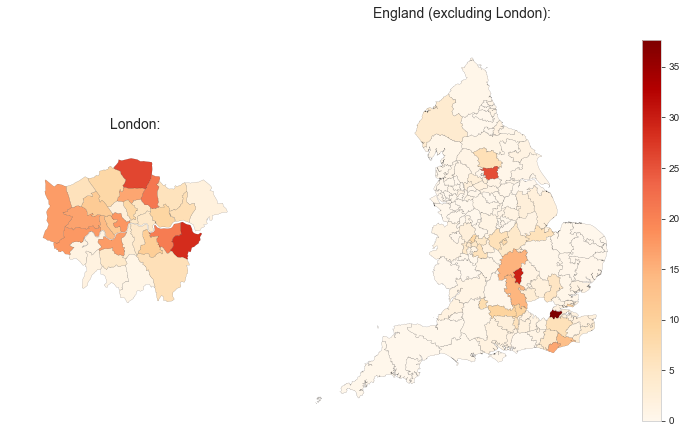

In [ ]:
from ebmdatalab import maps
plt.figure(figsize=(12, 7))
maps.ccg_map(map_data, title="", column='10mg measure', 
             separate_london=True)
plt.savefig('map.png', format='png', dpi=300,bbox_inches='tight')
plt.show()

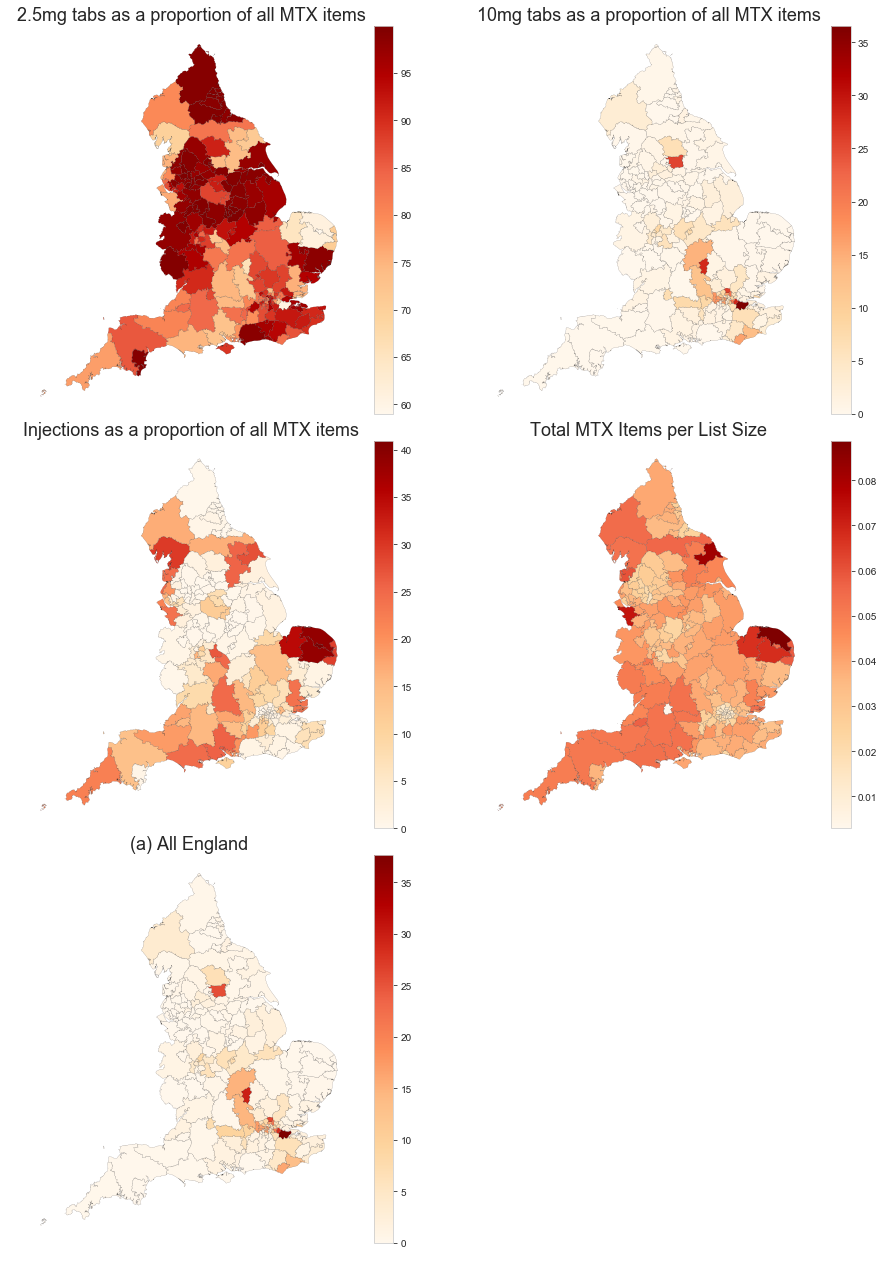

In [ ]:
# from our API https://openprescribing.net/api/1.0/org_location/?org_type=ccg
ccgs = gpd.read_file('ccgs.json').set_index('name')

ccgs = ccgs[~ccgs['geometry'].isnull()]  # remove ones without geometry - these are federations rather than individual CCGs
ccgs = ccgs.drop(columns='code')
gdf = ccgs.join(map_data)

# set sort order of measures manually, and add grid refs to position each subplot:
s = [(0,'2.5mg tabs',0,0,' 2.5mg tabs as a proportion of all MTX items'), 
     (1,'10mg tabs',0,1,' 10mg tabs as a proportion of all MTX items'),
     (2,'injections',1,0,' Injections as a proportion of all MTX items'),
     (3,'total_mtx_items',1,1, ' Total MTX Items per List Size'),
    (4,'10mg measure',2,0, '(a) All England')]

fig = plt.figure(figsize=(16,30))
gs = gridspec.GridSpec(4,2)  # grid layout for subplots

for i in s:
    ax = plt.subplot(gs[i[2], i[3]])  # position of subplot in grid using coordinates listed in s
    gdf.plot(ax=ax,column=i[1],  edgecolor='black', linewidth=0.1, legend=True, cmap='OrRd')
    ax.set_aspect(1.63)
    ax.set_title(i[4],size = 18)
    plt.axis('off')

plt.subplots_adjust(wspace = 0.05,hspace = 0.07)
plt.savefig('maps.png', format='png', dpi=300,bbox_inches='tight')

plt.show()

In [ ]:
plt.show()# from our API https://openprescribing.net/api/1.0/org_location/?org_type=ccg
ccgs = gpd.read_file('ccgs.json').set_index('name')

ccgs = ccgs[~ccgs['geometry'].isnull()]  # remove ones without geometry - these are federations rather than individual CCGs
ccgs = ccgs.drop(columns='code')
gdf = ccgs.join(map_data)
gdf = gdf.loc[(gdf["pct"]=="08H") 
              | (gdf["pct"]=="07L")
              | (gdf["pct"]=="07M")
              | (gdf["pct"]=="07N")
              | (gdf["pct"]=="8M")
              | (gdf["pct"]=="07P")
              | (gdf["pct"]=="07Q")
              | (gdf["pct"]=="07R")
              | (gdf["pct"]=="09A")
              | (gdf["pct"]=="07T")
              | (gdf["pct"]=="07V")
              | (gdf["pct"]=="07X")
              | (gdf["pct"]=="07W")
              | (gdf["pct"]=="08A")
              | (gdf["pct"]=="08C")
              | (gdf["pct"]=="08D")
              | (gdf["pct"]=="08E")
              | (gdf["pct"]=="08F")
              | (gdf["pct"]=="08G")
              | (gdf["pct"]=="07Y")
              | (gdf["pct"]=="08J")
              | (gdf["pct"]=="08K")
              | (gdf["pct"]=="08L")
              | (gdf["pct"]=="08R")
              | (gdf["pct"]=="08Q")
              | (gdf["pct"]=="08T")
              | (gdf["pct"]=="08V")
              | (gdf["pct"]=="08W")
              | (gdf["pct"]=="08X")
              | (gdf["pct"]=="08Y")
              | (gdf["pct"]=="08M")
              | (gdf["pct"]=="08N")
              | (gdf["pct"]=="08P")
              ]             
            #zoom in London

# set sort order of measures manually, and add grid refs to position each subplot:
s = [(0,'2.5mg tabs',0,0,'2.5mg tabs as a proportion of all MTX items'), 
     (1,'10mg tabs',0,1,'10mg tabs as a proportion of all MTX items'),
     (2,'injections',1,0,'Injections as a proportion of all MTX items'),
     (3,'total_mtx_items',1,1, 'Total MTX Items per List Size'),
    (4,'10mg measure',2,0, '(b) London')]

fig = plt.figure(figsize=(16,30))
gs = gridspec.GridSpec(4,2)  # grid layout for subplots

for i in s:
    ax = plt.subplot(gs[i[2], i[3]])  # position of subplot in grid using coordinates listed in s
    gdf.plot(ax=ax,column=i[1],  edgecolor='black', linewidth=0.1, legend=True, cmap='OrRd')
    ax.set_aspect(1.63)
    ax.set_title(i[4],size = 18)
    plt.axis('off')

plt.subplots_adjust(wspace = 0.05,hspace = 0.07)
plt.savefig('maps.png', format='png', dpi=300,bbox_inches='tight')

plt.show()

## Merge data for regression model (see Stata code)

In [ ]:
last_year = all_mtx.loc[(all_mtx.list_size>1000) & (~pd.isnull(all_mtx.list_size)) & (all_mtx["month"]>="2017-01-01")]
last_year = last_year[['practice','pct','mtx_2_5', 'mtx_10', 'list_size']]

last_year = last_year.groupby(['practice','pct'],as_index=False).sum()
last_year['rate'] = last_year['mtx_10']/(last_year['mtx_2_5'] + last_year['mtx_10'])
last_year = last_year[['practice','pct','rate']]
last_year['rate'].quantile([0.1,0.5,0.9])

In [ ]:
last_year.loc[last_year['rate']>0].count()#.hist(bins=50)
#plt.show()

In [ ]:
last_year.loc[last_year['rate']>0]